In this notebook we'll determine how much of the variance in the IPGCA embedding is explained by each of the metadata covariates (e.g. technical and biological effect, etc.).

1.Global setting

In [266]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
import os
import copy
from adjustText import adjust_text

sys.path.append("/disk212/yupf/code/HLCA_reproducibility/scripts")
import utils2
import analysis

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import entropy

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [275]:
path_HLCA = "/disk212/yupf/database/scRNA-seq/NewAtlas/atlas_level3_v3.h5ad"
dir_results = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/depth/"
dir_figures = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/depth/figures/"

2.prepare dataset(IPGCA)

In [235]:
adata = sc.read(path_HLCA)

In [236]:
adata

AnnData object with n_obs × n_vars = 589101 × 19346
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'Lineage', 'CellType', 'lym', 'level3', 'Dataset', 'segment', 'stage', 'weaned', 'Disease', 'gender', 'region', 'breed', 'project', 'age'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CellType_colors', 'Lineage_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'level3_colors', 'lym_colors', 'majority_voting_colors', 'neighbors', 'project_colors', 'stage_colors', 'tsne', 'umap'
    obsm: 'X_scVI', 'X_tsne', 'X_umap', '_scvi_extra_categorical_covs'
    obsp: 'connectivities', 'distances'

In [257]:
depth_meta=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/other_cov/depth_meta.txt',sep='\t')
depth_meta

,Mean Reads per Cell,Sequencing Saturation,sample
0,"28,342",43.3,PRJNA681248_ileum0
1,"16,114",39.3,PRJNA681248_ileum1
2,"25,182",43.5,PRJNA681248_ileum3
3,"22,394",43.4,PRJNA681248_ileum7
4,"18,958",34.8,PRJNA681248_ileum14
...,...,...,...
66,"33,397",62.6,Ss_DU
67,"46,478",72.2,Ss_JE
68,"47,223",75.8,Ss_IL
69,"48,541",54.2,Ss_CE


In [258]:
depth_meta['Sequencing Saturation']= depth_meta['Sequencing Saturation']/100

In [259]:
map1=dict(zip(depth_meta['sample'],depth_meta['Sequencing Saturation']))
map2=dict(zip(depth_meta['sample'],depth_meta['Mean Reads per Cell']))

In [262]:
len(set(adata.obs['Dataset'].unique())&set(depth_meta['sample']))

70

In [263]:
adata.obs['Mean_Reads_per_Cell']=adata.obs['Dataset'].map(map2)

In [264]:
adata.obs['Sequencing_Saturation']=adata.obs['Dataset'].map(map1)

determine covariates to investigate

In [332]:
covariates = [ 'total_counts','doublet_score','Sequencing_Saturation','pct_counts_mt', 'segment', 'stage', 'weaned', 'phase', 'gender', 'region', 'breed']

In [333]:
adata

AnnData object with n_obs × n_vars = 589101 × 19346
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'Lineage', 'CellType', 'lym', 'level3', 'Dataset', 'segment', 'stage', 'weaned', 'Disease', 'gender', 'region', 'breed', 'project', 'age', 'Mean_Reads_per_Cell', 'Sequencing_Saturation'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CellType_colors', 'Lineage_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'level3_colors', 'lym_colors', 'majority_voting_colors', 'neighbors', 'project_colors', 'stage_colors', 'tsne', 'umap'
    obsm: 'X_scVI', 'X_tsne', 'X_umap', '_scvi_extra_categorical_covs'
    obsp: 'connectivities', 'distances'

sanity check:

In [334]:
for cov in covariates:
    if type(adata.obs[cov].values) == pd.Categorical:
        print(cov.upper())
        print(set(adata.obs[cov]))
        print("\n")
    else:
        print(cov.upper(), "not a categorical.\n")

TOTAL_COUNTS not a categorical.

DOUBLET_SCORE not a categorical.

SEQUENCING_SATURATION not a categorical.

PCT_COUNTS_MT not a categorical.

SEGMENT
{'duodenum', 'Mixed', 'cecum', 'colon', 'ileum', 'jejunum'}


STAGE
{'Feeder', 'Weaning', 'Adult', 'Weaner', 'Newborn', 'Piglet'}


WEANED
{'before', 'after', nan}


PHASE
{'G1', 'S', 'G2M'}


GENDER
{'female', 'male', nan}


REGION
{'Mixed', 'SmallInt', 'LargeInt'}


BREED
{'Mixed', 'DLY', 'Jinhua', 'Sus scrofa', 'large white', 'LY', 'Bama', 'Duroc'}




We will now perform a linear regression for every latent component with every covariate selected above. Where the covariate is continuous or binary (two categories, converted to a single vector of 0s and 1s), we can do a simple linear regression explaining our y variable (component) based on our x variable (metadata category). Where the covariate is a categorical with more than two categories, we'll have to create "dummies", generating a 1-hot encoded binary variable for (n_categories - 1) categories, and perform a linear regression explaining our y variable based on the resulting multi-variate matrix. Minimum number of total cells of a cell type to be considered for analysis, minimum number of cells of a cell type for a sample to be included in the analysis, and minimum number of samples passing that criterium for a cell type to be analysed:

In [303]:
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2

check if needed output dirs exists, if not, create them:

In [335]:
outdir_1 = os.path.join(dir_results, f"variance_explained_fractions/")
if not os.path.exists(outdir_1):
    print("Creating directory:", outdir_1)
    os.makedirs(outdir_1)
outdir_2 = os.path.join(dir_results, f"samples_included/")
if not os.path.exists(outdir_2):
    print("Creating directory:", outdir_2)
    os.mkdir(outdir_2)

Creating directory: /disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/depth/variance_explained_fractions/
Creating directory: /disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/depth/samples_included/


In [336]:
adata.obs.Lineage.unique()

['B lineage', 'Epithelial lineage', 'T/ILC lineage', 'Myeloid lineage', 'Mesenchymal lineage', 'Endothelial lineage', 'Neuron Lineage', 'Red blood']
Categories (8, object): ['Epithelial lineage', 'B lineage', 'T/ILC lineage', 'Myeloid lineage', 'Endothelial lineage', 'Mesenchymal lineage', 'Neuron Lineage', 'Red blood']

In [337]:
# Initiate a dictionary, in which we will store which samples were included per
# single regression
samples_included = dict()
cts_to_skip = list()  # we will fill this with cts that have too few samples
# these samples should be skipped in the rest of the analysis.
# Loop through specified integration types:

samples_included = dict()
# loop through all annotations (= cell types), and also include the entire
# atlas as a "cell type":
for subset in sorted(adata.obs.Lineage.unique()) + ["whole_atlas"]:
    # remove space from cell type name, for file storing etc.
    subset_no_space = subset.replace(" ", "_")
    subset_no_space = subset_no_space.replace("/", "_")
    # initiate a dataframe, in which we will store for every covariate
    # which samples we include in the regression (we will exclude samples
    # that have no value available for the covariate under consideration
    # (e.g. BMI not recorded), as well as samples that have fewer than 10
    # cells of the cell type under consideration)
    samples_included[subset] = pd.DataFrame(
        index=adata.obs["project"].unique(), columns=covariates
    )
    # if file doesn't exist yet (built in this check for if loop breaks halfway,
    # feel free to take it out):
    if not os.path.isfile(
        os.path.join(
            dir_results,
            f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
        )
    ):
        print(f"Working on {subset}...")
        # select the correct cells:
        if subset == "whole_atlas":
            subadata = adata.copy()
            verbose = True
        elif subset not in adata.obs.Lineage.unique():
            raise ValueError(
                "subset should be set either to 'Whole atlas' or to a category in your manual_ann grouped obs variable!"
            )
        else:
            subadata = adata[adata.obs.Lineage == subset, :].copy()
            verbose = False
        if subadata.n_obs < min_n_cells_total:
            print(f"{subset} has fewer than {min_n_cells_total} cells! Skipping.")
            continue
        emb_name = "X_scVI"
        
        # store the number of components in our embedding of choice
        n_comps = subadata.obsm[emb_name].shape[1]
        # initiate a dataframe in which we'll store the variance explained
        # by each covariate, plus the total variance ("overall") observed
        var_explained = pd.DataFrame(
            index=range(n_comps), columns=covariates + ["overall"]
        )
        # initiate a dataframe in which we will store the data
        # for our linear regression (i.e. the PC/latent components, + covariates).
        # Rows are cells, but we will collapse this to samples below
        comp_sample_df = pd.DataFrame(index=subadata.obs.index)
        comp_sample_df["sample"] = subadata.obs["project"]
        # prepare aggregation dictionary for collapsing into sample-wise
        # observations
        agg_dict = {"sample": "count"}  # this will be number of cells
        for comp in range(n_comps):
            # store component scores per cell
            comp_sample_df[f"comp{comp}"] = subadata.obsm[emb_name][:, comp]
            # we will aggregate these later by taking the mean per sample
            agg_dict[f"comp{comp}"] = "mean"
        for cov in covariates:
            if cov in ["log10_total_counts", "mito_frac"]:
                # store values
                comp_sample_df[cov] = subadata.obs[cov]
                # we will aggregate by taking the mean
                agg_dict[cov] = "mean"
            else:
                # for all other covariates: these are sample-level
                # covariates, so we will take the "first" overservation
                # in the sample (which should be the only)
                comp_sample_df[cov] = subadata.obs[cov]
                agg_dict[cov] = "first"
        # now collapse into sample-level observations
        sample_df = (
            comp_sample_df.groupby("sample")
            .agg(agg_dict)
            .rename(columns={"sample": "n_cells"})
        )
        # filter out samples with fewer than min_n_cells cells of the cell type
        sample_df = sample_df.loc[
            sample_df.n_cells >= min_n_cells,
        ].copy()
        # check number of samples left.
        # If fewer than min_n_samples remain, we will skip the cell type
        if sample_df.shape[0] < min_n_samples:
            print(
                f"Only {sample_df.shape[0]} samples available for {subset}. Skipping."
            )
            cts_to_skip.append(subset)
            continue
        # Otherwise, move on to the linear regression:
        # do a linear regression on each component, with the component scores
        # as response variable...
        for comp in range(n_comps):
            # store the component values (for all samples i.e. unfiltered)
            y_true_unfiltered = sample_df.loc[:, f"comp{comp}"].values
            # and store variance of y_true as "overall" variance
            var_explained.loc[f"comp{comp}", "overall"] = np.var(y_true_unfiltered)
            # and the covariate as fixed variable
            for cov in covariates:
                # store covariate observations under x
                x = sample_df[cov].values.copy()
                # store samples to which they match
                x_samples = sample_df.index
                # check which of these samples have no observation (e.g.
                # because BMI was unknown, or age, etc.)
                # (the function used below checks for different kinds of
                # nas, e.g. np.nan, "nan", None, "None" etc.)
                x_nans = np.vectorize(utils2.check_if_nan)(x)
                # now keep only xs that have real observations
                x = x[~x_nans]
                # if only one or no observations are left, skip this covariate
                if len(x) < 2:
                    continue
                # filter samples according to x filtering
                x_samples = x_samples[~x_nans]
                # and store which samples were included in our samples_included
                # dictionary, for later reference (this is our "n")
                samples_included[subset][cov] = samples_included[subset].index.isin(x_samples.tolist())
                # filter y_true according to x's filtering
                y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                # prepare x for linear regression:
                # if it is a float (e.g. BMI, age), all we need to do is reshape:
                if x.dtype in ["float32", "float", "float64"]:
                    x = x.reshape(-1, 1)
                    # print that we are treating as numerical (only for first comp,
                    # so that we don't print the same thing many times)
                    if comp == 0 and verbose:
                        print(f"treating {cov} as continuous variable")
                # otherwise we are dealing with a categorical...
                else:
                    # if it has only one category, there is 0 variance and
                    # we cannot perform linear regression. In that case,
                    # move on to the next covariate.
                    if len(set(x)) == 1:
                        var_explained.loc[comp, cov] = np.nan
                        continue
                    # Otherwise, convert x to dummied variable:
                    # print that we are converting to dummy
                    # (only do it for the first comp, otherwise we print the same thing
                    # many times)
                    if comp == 0 and verbose:
                        print(f"converting {cov} to dummy variable")
                    # drop_first means we ensure that are x is full rank,
                    # and we only encode all-1 categories
                    x = pd.get_dummies(x, drop_first=True)
                # now perform linear regression
                lrf = LinearRegression(fit_intercept=True).fit(
                    x,
                    y_true,
                )
                # predict y based on the fit linear model
                y_pred = lrf.predict(x)
                # and store the variance of the predicted y, this is the
                # "variance explained" by the covariate, for this component
                var_explained.loc[comp, cov] = np.var(y_pred)
        # for each covariate, sum up how much variance it explains across
        # the components (i.e. PCs or scANVI latent components)
        # Sort covariates from explaining most to explaining least
        total_variance_explained = np.sum(var_explained, axis=0).sort_values(
            ascending=False
        )
        # divide this by the total variance that was observed in the
        # components, to get fraction of variance explained
        total_variance_explained_fractions = (
            total_variance_explained / total_variance_explained["overall"]
        )
        # write to files:
        # 1) variance explained fractions, for this integration type and cell type
        total_variance_explained_fractions.to_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
            )
        )
        # 2) samples included, for this cell type
        samples_included[subset].to_csv(
            os.path.join(
                dir_results,
                f"samples_included/samples_included_{subset_no_space}.csv",
            )
        )

Working on B lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Endothelial lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Epithelial lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Mesenchymal lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Myeloid lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Neuron Lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Red blood...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on T/ILC lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on whole_atlas...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


treating total_counts as continuous variable
treating doublet_score as continuous variable
treating Sequencing_Saturation as continuous variable
treating pct_counts_mt as continuous variable
converting segment to dummy variable
converting stage to dummy variable
converting weaned to dummy variable
converting phase to dummy variable
converting gender to dummy variable
converting region to dummy variable
converting breed to dummy variable


In [338]:
cts_to_skip=['Red blood']

In [339]:
subsets = ["whole_atlas"] + sorted(adata.obs.Lineage.unique())
# import variance explained fractions for the Whole atlas, to get indices
# and columns for dataframes
vef_df = pd.read_csv(
    os.path.join(
        dir_results,
        f"variance_explained_fractions/variance_explained_fractions_whole_atlas.csv",
    ),
    index_col=0,
).rename(columns={"0": "uncorrected"})
# inititate empty dataframes for variance explained fractions
vars_expl = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip], columns=vef_df.index
)
# initiate an empty dictionary to store samples included for each cell type - cov
# pair
samples_included = dict()
# loop through cell types + Whole atlas
for subset in subsets:
    if subset not in cts_to_skip:
        # replace spaces in cell type name with "_" for file writing etc.
        subset_no_space = subset.replace(" ", "_")
        subset_no_space = subset_no_space.replace("/", "_")
        # import variance explained fractions:
        vef_df = pd.read_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
            ),
            index_col=0,
        ).rename(columns={"0": "uncorrected"})
        # store values in our overview dataframes
        vars_expl.loc[subset, vef_df.index] = vef_df.values.reshape(1, -1)
        # store which samples were included for each covariate based on matching file
        samples_included[subset] = pd.read_csv(
            os.path.join(
                dir_results, f"samples_included/samples_included_{subset_no_space}.csv"
            ),
            index_col=0,
        )
# rename "whole_atlas" to "Whole atlas" index, for prettier plotting
vars_expl.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [340]:
vars_expl

,overall,breed,stage,segment,phase,weaned,region,Sequencing_Saturation,pct_counts_mt,gender,total_counts,doublet_score
Whole atlas,1.0,0.327014,0.26818,0.205677,0.100793,0.092133,0.069372,0.063821,0.04335,0.025171,0.020846,0.009107
B lineage,1.0,0.26715,0.211071,0.203624,0.075886,0.073133,0.028079,0.117777,0.041224,0.040234,0.056557,0.019104
Endothelial lineage,1.0,0.267594,0.20757,0.102786,0.035585,0.110229,0.030241,0.054889,0.024441,0.122146,0.027011,0.031088
Epithelial lineage,1.0,0.381328,0.253163,0.175087,0.074478,0.055316,0.10578,0.131955,0.036726,0.021829,0.026992,0.006982
Mesenchymal lineage,1.0,0.445209,0.297711,0.240489,0.032764,0.130962,0.123504,0.068312,0.072998,0.089582,0.034759,0.031969
Myeloid lineage,1.0,0.287982,0.221726,0.183781,0.028447,0.072729,0.088785,0.073598,0.041207,0.033235,0.012175,0.006563
Neuron Lineage,1.0,0.368357,0.451142,0.263262,0.060303,0.321507,0.108133,0.0616,0.02312,0.01059,0.025115,0.01625
T/ILC lineage,1.0,0.397903,0.356253,0.109174,0.025778,0.15584,0.053637,0.122834,0.017001,0.025988,0.015491,0.015536


In [341]:
cat_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    not in [
        "float32",
        "float",
        "float64",
    ]
]
# and continuous/numerical covariates
cont_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    in [
        "float32",
        "float",
        "float64",
    ]
]

In [342]:
print(cat_covs)

['segment', 'stage', 'weaned', 'phase', 'gender', 'region', 'breed']


In [343]:
print(cont_covs)

['total_counts', 'doublet_score', 'Sequencing_Saturation', 'pct_counts_mt']


In [344]:
# aggregate values by sample
agg_dict = {cov: "first" for cov in cat_covs}  # use "first" for categorical
agg_dict.update({cov: "mean" for cov in cont_covs})  # and "mean" for continuous
# collect statistics:
sample_df = adata.obs.groupby("project").agg(agg_dict)
# initiate dataframe where we store for every cell type, for every covariate,
# how many unique values are observed
n_cats_per_cov = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip],
    columns=cat_covs + cont_covs + ["project"],
)
# loop through cell types and categorical covariates
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cat_covs:
            # annotation will always be one (this might change if we set our
            # cell type variable differently!)
            if cov == "Lineage":
                n_cats_per_cov[cov] = 1
            else:
                # extract covariate values only for samples included for cell type
                # and covariate
                sample_df_subset = sample_df.loc[
                    samples_included[subset].index[samples_included[subset][cov]], :
                ].copy()
                # count number of unique values
                n_per_cov = sample_df_subset[cov].nunique()
                # store
                n_cats_per_cov.loc[subset, cov] = n_per_cov
        # store number of samples included as the maximum number of samples included,
        # across covariates, for a cell type
        n_cats_per_cov.loc[subset, "project"] = (
            samples_included[subset].sum(axis=0).max()
        )

# now create boolean df indicating in which cases only one unique value
# was observed for a cell type covariate pair
nis1 = n_cats_per_cov == 1
nis1.index = list(nis1.index)
nis1.loc["Whole atlas", :] = [
    adata.obs[cat_cov].nunique() == 1 for cat_cov in nis1.columns
]
#  now loop through continuous covariates and calculate variance instead of number
# of unique variables. If variance is 0, set nis1 to True.
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cont_covs:
            sample_df_subset = sample_df.loc[
                samples_included[subset].index[
                    (samples_included[subset].sum(axis=1) > 0)
                ],
                :,
            ].copy()
            variance = np.var(sample_df_subset[cov])
            if variance == 0 or np.isnan(variance):
                nis1.loc[subset, cov] = True
            else:
                nis1.loc[subset, cov] = False
nis1["overall"] = False

/tmp/ipykernel_480187/1969518002.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_df = adata.obs.groupby("project").agg(agg_dict)


In [345]:
nis1

,segment,stage,weaned,phase,gender,region,breed,total_counts,doublet_score,Sequencing_Saturation,pct_counts_mt,project,overall
whole_atlas,False,False,False,False,False,False,False,False,False,False,False,False,False
B lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Endothelial lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Epithelial lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Mesenchymal lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Myeloid lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Neuron Lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
T/ILC lineage,False,False,False,False,False,False,False,False,False,False,False,False,False
Whole atlas,False,False,False,False,False,False,False,False,False,False,False,False,False


In [346]:
n_samples_included_df = pd.DataFrame(index=samples_included.keys(), columns=covariates)
for ct, samp_incl in samples_included.items():
    n_samples_included_df.loc[ct, :] = samp_incl.loc[:, covariates].sum(axis=0)

In [347]:
cts_ordered = [
    ct
    for ct in n_cats_per_cov.sort_values(by="project", ascending=False).index.tolist()
    if ct != "whole_atlas"
]

In [348]:
cts_ordered=[
    'B lineage',
    'Epithelial lineage',
     'Myeloid lineage',
    'T/ILC lineage',
    'Neuron Lineage',
 'Mesenchymal lineage',
 'Endothelial lineage']

In [359]:
nis1.columns

Index(['segment', 'stage', 'weaned', 'phase', 'gender', 'region', 'breed',
       'total_counts', 'doublet_score', 'Sequencing_Saturation',
       'pct_counts_mt', 'project', 'overall'],
      dtype='object')

In [364]:
technical_covariates = [
    'total_counts',
    'Sequencing_Saturation',
    'pct_counts_mt',
    'doublet_score'
]
# specify bio covariates to show
bio_covariates = [
     'breed','stage', 'segment','phase','weaned', 'region', 'gender'
       
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
# technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
# bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[
    ["Whole atlas"] + cts_ordered,
    technical_covariates + bio_covariates,
]

In [366]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}
# We re-name some of the categories for clarity in the paper:
renaming = {
    "pct_counts_mt": "MT gene",
    "total_counts": "Sequence depth",
    'Sequencing_Saturation': "Sequencing saturation",
    "doublet_score": "Doublet score",
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# and remove dataset from figure
# vars_expl_to_plot.drop(columns="project", inplace=True)

In [367]:
mask1 = (
    n_samples_included_df.loc[
        ["whole_atlas"] + vars_expl.index[1:].tolist(),
        vars_expl.columns,
    ]
    < 10
)

In [368]:
mask2 = nis1.loc[
    ["whole_atlas"] + vars_expl.index[1:].tolist(),
    vars_expl.columns,
]

In [369]:
# combine masks
mask_overall = mask1 | mask2
# rename Whole atlas
mask_overall.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [370]:
if "dataset" in mask_overall.columns:
    mask_overall.drop(columns="dataset", inplace=True)
mask_overall.rename(columns=col_remapper, inplace=True)

In [371]:
n_non_masked_rows = mask_overall.shape[0] - (mask_overall == True).sum(axis=0)
columns_to_drop = n_non_masked_rows.loc[n_non_masked_rows < 5].index.tolist()

In [372]:
vars_expl_to_plot.drop(columns=columns_to_drop, inplace=True)
mask_overall.drop(columns=columns_to_drop, inplace=True)

/tmp/ipykernel_480187/3840322884.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(cm.get_cmap("Reds"))  # select color map


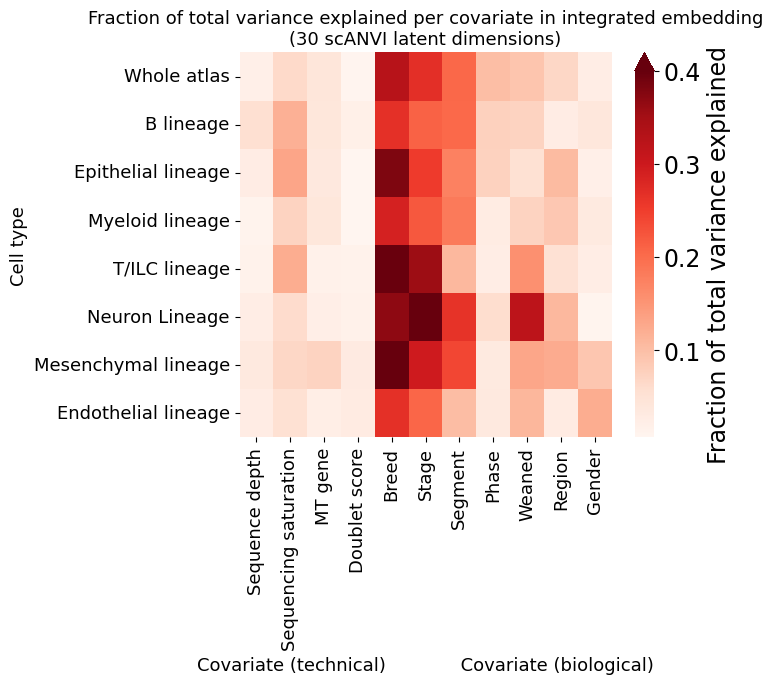

In [377]:
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
fig, ax = plt.subplots(figsize=(6, 5))  # figsize
vmax = 0.4
title = "Fraction of total variance"
# for file storing:
title_no_spaces = title.replace(" ", "_")
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax,
    vmax=vmax,
    cbar_kws={"extend": "max"},
    mask=mask_overall.loc[vars_expl_to_plot.index, vars_expl_to_plot.columns].values,
    cmap=cmap,
)
ax.collections[0].colorbar.set_label(f"{title} explained", fontsize=fz + 4)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fz)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fz)
plt.title(
    f"{title} explained per covariate in integrated embedding\n(30 scANVI latent dimensions)",
    fontsize=fz,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fz + 4)
plt.xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
plt.ylabel("Cell type", fontsize=fz)
plt.savefig(f'/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/new_cov_var.pdf', dpi=300, bbox_inches='tight')
plt.show()
# FIGURES[f"4a_{title_no_spaces}_explained_per_covariate_{int_type}_emb"] = fig

extend 复刻

In [378]:
dir_results = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/"
dir_figures = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/figures/"
path_extend='/disk212/yupf/database/scRNA-seq/NewAtlas/IPGCA_Extend/celltypist_data/extend_conf08.h5ad'

In [379]:
adata = sc.read(path_extend)

In [381]:
adata

AnnData object with n_obs × n_vars = 485026 × 25238
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'project', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden_1.0', 'Dataset', 'segment', 'stage', 'age', 'weaned', 'disease', 'gender', 'region', 'breed', 'platform', 'sequence_method', 'Project', 'Lineage', 'leiden_lineage', 'CellType'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'

In [385]:
depth_extend=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/other_cov/depth_meta_extend.csv')
depth_extend

,Mean Reads per Cell,Sequencing Saturation,sample
0,"36,097",52.3,CRR1248479_GF_MLN
1,"40,546",47.8,CRR1248478_GF_JPP
2,"4,738",36.9,SRR17874772_Nopp1_3
3,"5,342",39.0,SRR17874743_Nopp1_2
4,"11,044",58.3,SRR22512796_ILCs12
5,"6,304",45.0,SRR22512797_ILCs11
6,"33,975",44.9,SRR24524075_I2_1
7,"35,196",46.6,SRR24524065_I3_1
8,"17,814",38.3,SRR32966020_Control
9,"21,355",42.9,SRR32966019_PEDV


In [386]:
depth_extend['Sequencing Saturation']= depth_extend['Sequencing Saturation']/100

In [387]:
len(set(depth_extend['sample'])&set(adata.obs['Dataset']))

59

In [388]:
map3=dict(zip(depth_extend['sample'],depth_extend['Sequencing Saturation']))
map4=dict(zip(depth_extend['sample'],depth_extend['Mean Reads per Cell']))

In [389]:
adata.obs['Sequencing Saturation'] = adata.obs['Dataset'].map(map3)
adata.obs['Mean_Reads_per_Cell'] = adata.obs['Dataset'].map(map4)

determine covariates to investigate

In [390]:
covariates = [ 'Sequencing Saturation','total_counts','doublet_score',  'pct_counts_mt', 'segment', 'stage','platform', 'sequence_method','weaned', 'phase', 'gender', 'region', 'breed']

sanity check:

In [391]:
for cov in covariates:
    if type(adata.obs[cov].values) == pd.Categorical:
        print(cov.upper())
        print(set(adata.obs[cov]))
        print("\n")
    else:
        print(cov.upper(), "not a categorical.\n")

SEQUENCING SATURATION not a categorical.

TOTAL_COUNTS not a categorical.

DOUBLET_SCORE not a categorical.

PCT_COUNTS_MT not a categorical.

SEGMENT
{'Ileum', 'Ileum(Mesenteric lymph node)', 'Cecum', 'Jejunum', "Ileum(Peyer's patches)", 'Duodenum', "Jejunum(Peyer's patches)", 'Colon'}


STAGE
{'Feeder', 'Weaning', 'Adult', 'Weaner', 'Piglet'}


PLATFORM
{'SeekOne', '10x Genomics'}


SEQUENCE_METHOD
{'scRNA-seq', 'snRNA-seq'}


WEANED
{'before', 'after'}


PHASE
{'G1', 'S', 'G2M'}


GENDER
{'Female', nan, 'Male', 'Mixed'}


REGION
{'SmallInt', 'LargeInt'}


BREED
{'Mixed', 'SPF', 'Bama', nan, 'Meishan'}




We will now perform a linear regression for every latent component with every covariate selected above. Where the covariate is continuous or binary (two categories, converted to a single vector of 0s and 1s), we can do a simple linear regression explaining our y variable (component) based on our x variable (metadata category). Where the covariate is a categorical with more than two categories, we'll have to create "dummies", generating a 1-hot encoded binary variable for (n_categories - 1) categories, and perform a linear regression explaining our y variable based on the resulting multi-variate matrix. Minimum number of total cells of a cell type to be considered for analysis, minimum number of cells of a cell type for a sample to be included in the analysis, and minimum number of samples passing that criterium for a cell type to be analysed:

In [392]:
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2

check if needed output dirs exists, if not, create them:

In [393]:
outdir_1 = os.path.join(dir_results, f"variance_explained_fractions/")
if not os.path.exists(outdir_1):
    print("Creating directory:", outdir_1)
    os.makedirs(outdir_1)
outdir_2 = os.path.join(dir_results, f"samples_included/")
if not os.path.exists(outdir_2):
    print("Creating directory:", outdir_2)
    os.mkdir(outdir_2)

Creating directory: /disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/variance_explained_fractions/
Creating directory: /disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/samples_included/


In [394]:
adata.obs.Lineage.unique()

['T/ILC lineage', 'Myeloid lineage', 'B lineage', 'Epithelial lineage', 'Mesenchymal lineage', 'Endothelial lineage', 'Neuron lineage']
Categories (7, object): ['T/ILC lineage', 'Myeloid lineage', 'B lineage', 'Epithelial lineage', 'Mesenchymal lineage', 'Endothelial lineage', 'Neuron lineage']

In [395]:
# Initiate a dictionary, in which we will store which samples were included per
# single regression
samples_included = dict()
cts_to_skip = list()  # we will fill this with cts that have too few samples
# these samples should be skipped in the rest of the analysis.
# Loop through specified integration types:

samples_included = dict()
# loop through all annotations (= cell types), and also include the entire
# atlas as a "cell type":
for subset in sorted(adata.obs.Lineage.unique()) + ["whole_atlas"]:
    # remove space from cell type name, for file storing etc.
    subset_no_space = subset.replace(" ", "_")
    subset_no_space = subset_no_space.replace("/", "_")
    # initiate a dataframe, in which we will store for every covariate
    # which samples we include in the regression (we will exclude samples
    # that have no value available for the covariate under consideration
    # (e.g. BMI not recorded), as well as samples that have fewer than 10
    # cells of the cell type under consideration)
    samples_included[subset] = pd.DataFrame(
        index=adata.obs["project"].unique(), columns=covariates
    )
    # if file doesn't exist yet (built in this check for if loop breaks halfway,
    # feel free to take it out):
    if not os.path.isfile(
        os.path.join(
            dir_results,
            f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
        )
    ):
        print(f"Working on {subset}...")
        # select the correct cells:
        if subset == "whole_atlas":
            subadata = adata.copy()
            verbose = True
        elif subset not in adata.obs.Lineage.unique():
            raise ValueError(
                "subset should be set either to 'Whole atlas' or to a category in your manual_ann grouped obs variable!"
            )
        else:
            subadata = adata[adata.obs.Lineage == subset, :].copy()
            verbose = False
        if subadata.n_obs < min_n_cells_total:
            print(f"{subset} has fewer than {min_n_cells_total} cells! Skipping.")
            continue
        emb_name = "X_scVI"
        
        # store the number of components in our embedding of choice
        n_comps = subadata.obsm[emb_name].shape[1]
        # initiate a dataframe in which we'll store the variance explained
        # by each covariate, plus the total variance ("overall") observed
        var_explained = pd.DataFrame(
            index=range(n_comps), columns=covariates + ["overall"]
        )
        # initiate a dataframe in which we will store the data
        # for our linear regression (i.e. the PC/latent components, + covariates).
        # Rows are cells, but we will collapse this to samples below
        comp_sample_df = pd.DataFrame(index=subadata.obs.index)
        comp_sample_df["sample"] = subadata.obs["project"]
        # prepare aggregation dictionary for collapsing into sample-wise
        # observations
        agg_dict = {"sample": "count"}  # this will be number of cells
        for comp in range(n_comps):
            # store component scores per cell
            comp_sample_df[f"comp{comp}"] = subadata.obsm[emb_name][:, comp]
            # we will aggregate these later by taking the mean per sample
            agg_dict[f"comp{comp}"] = "mean"
        for cov in covariates:
            if cov in ["log10_total_counts", "mito_frac"]:
                # store values
                comp_sample_df[cov] = subadata.obs[cov]
                # we will aggregate by taking the mean
                agg_dict[cov] = "mean"
            else:
                # for all other covariates: these are sample-level
                # covariates, so we will take the "first" overservation
                # in the sample (which should be the only)
                comp_sample_df[cov] = subadata.obs[cov]
                agg_dict[cov] = "first"
        # now collapse into sample-level observations
        sample_df = (
            comp_sample_df.groupby("sample")
            .agg(agg_dict)
            .rename(columns={"sample": "n_cells"})
        )
        # filter out samples with fewer than min_n_cells cells of the cell type
        sample_df = sample_df.loc[
            sample_df.n_cells >= min_n_cells,
        ].copy()
        # check number of samples left.
        # If fewer than min_n_samples remain, we will skip the cell type
        if sample_df.shape[0] < min_n_samples:
            print(
                f"Only {sample_df.shape[0]} samples available for {subset}. Skipping."
            )
            cts_to_skip.append(subset)
            continue
        # Otherwise, move on to the linear regression:
        # do a linear regression on each component, with the component scores
        # as response variable...
        for comp in range(n_comps):
            # store the component values (for all samples i.e. unfiltered)
            y_true_unfiltered = sample_df.loc[:, f"comp{comp}"].values
            # and store variance of y_true as "overall" variance
            var_explained.loc[f"comp{comp}", "overall"] = np.var(y_true_unfiltered)
            # and the covariate as fixed variable
            for cov in covariates:
                # store covariate observations under x
                x = sample_df[cov].values.copy()
                # store samples to which they match
                x_samples = sample_df.index
                # check which of these samples have no observation (e.g.
                # because BMI was unknown, or age, etc.)
                # (the function used below checks for different kinds of
                # nas, e.g. np.nan, "nan", None, "None" etc.)
                x_nans = np.vectorize(utils2.check_if_nan)(x)
                # now keep only xs that have real observations
                x = x[~x_nans]
                # if only one or no observations are left, skip this covariate
                if len(x) < 2:
                    continue
                # filter samples according to x filtering
                x_samples = x_samples[~x_nans]
                # and store which samples were included in our samples_included
                # dictionary, for later reference (this is our "n")
                samples_included[subset][cov] = samples_included[subset].index.isin(x_samples.tolist())
                # filter y_true according to x's filtering
                y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                # prepare x for linear regression:
                # if it is a float (e.g. BMI, age), all we need to do is reshape:
                if x.dtype in ["float32", "float", "float64"]:
                    x = x.reshape(-1, 1)
                    # print that we are treating as numerical (only for first comp,
                    # so that we don't print the same thing many times)
                    if comp == 0 and verbose:
                        print(f"treating {cov} as continuous variable")
                # otherwise we are dealing with a categorical...
                else:
                    # if it has only one category, there is 0 variance and
                    # we cannot perform linear regression. In that case,
                    # move on to the next covariate.
                    if len(set(x)) == 1:
                        var_explained.loc[comp, cov] = np.nan
                        continue
                    # Otherwise, convert x to dummied variable:
                    # print that we are converting to dummy
                    # (only do it for the first comp, otherwise we print the same thing
                    # many times)
                    if comp == 0 and verbose:
                        print(f"converting {cov} to dummy variable")
                    # drop_first means we ensure that are x is full rank,
                    # and we only encode all-1 categories
                    x = pd.get_dummies(x, drop_first=True)
                # now perform linear regression
                lrf = LinearRegression(fit_intercept=True).fit(
                    x,
                    y_true,
                )
                # predict y based on the fit linear model
                y_pred = lrf.predict(x)
                # and store the variance of the predicted y, this is the
                # "variance explained" by the covariate, for this component
                var_explained.loc[comp, cov] = np.var(y_pred)
        # for each covariate, sum up how much variance it explains across
        # the components (i.e. PCs or scANVI latent components)
        # Sort covariates from explaining most to explaining least
        total_variance_explained = np.sum(var_explained, axis=0).sort_values(
            ascending=False
        )
        # divide this by the total variance that was observed in the
        # components, to get fraction of variance explained
        total_variance_explained_fractions = (
            total_variance_explained / total_variance_explained["overall"]
        )
        # write to files:
        # 1) variance explained fractions, for this integration type and cell type
        total_variance_explained_fractions.to_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
            )
        )
        # 2) samples included, for this cell type
        samples_included[subset].to_csv(
            os.path.join(
                dir_results,
                f"samples_included/samples_included_{subset_no_space}.csv",
            )
        )

Working on B lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Endothelial lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Epithelial lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Mesenchymal lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Myeloid lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on Neuron lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on T/ILC lineage...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


Working on whole_atlas...


/tmp/ipykernel_480187/723293237.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_sample_df.groupby("sample")


treating Sequencing Saturation as continuous variable
treating total_counts as continuous variable
treating doublet_score as continuous variable
treating pct_counts_mt as continuous variable
converting segment to dummy variable
converting stage to dummy variable
converting platform to dummy variable
converting sequence_method to dummy variable
converting weaned to dummy variable
converting phase to dummy variable
converting gender to dummy variable
converting region to dummy variable
converting breed to dummy variable


In [396]:
cts_to_skip=['Red blood']

In [397]:
subsets = ["whole_atlas"] + sorted(adata.obs.Lineage.unique())
# import variance explained fractions for the Whole atlas, to get indices
# and columns for dataframes
vef_df = pd.read_csv(
    os.path.join(
        dir_results,
        f"variance_explained_fractions/variance_explained_fractions_whole_atlas.csv",
    ),
    index_col=0,
).rename(columns={"0": "uncorrected"})
# inititate empty dataframes for variance explained fractions
vars_expl = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip], columns=vef_df.index
)
# initiate an empty dictionary to store samples included for each cell type - cov
# pair
samples_included = dict()
# loop through cell types + Whole atlas
for subset in subsets:
    if subset not in cts_to_skip:
        # replace spaces in cell type name with "_" for file writing etc.
        subset_no_space = subset.replace(" ", "_")
        subset_no_space = subset_no_space.replace("/", "_")
        # import variance explained fractions:
        vef_df = pd.read_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}.csv",
            ),
            index_col=0,
        ).rename(columns={"0": "uncorrected"})
        # store values in our overview dataframes
        vars_expl.loc[subset, vef_df.index] = vef_df.values.reshape(1, -1)
        # store which samples were included for each covariate based on matching file
        samples_included[subset] = pd.read_csv(
            os.path.join(
                dir_results, f"samples_included/samples_included_{subset_no_space}.csv"
            ),
            index_col=0,
        )
# rename "whole_atlas" to "Whole atlas" index, for prettier plotting
vars_expl.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [398]:
vars_expl

,overall,breed,segment,stage,gender,sequence_method,total_counts,region,platform,phase,weaned,pct_counts_mt,Sequencing Saturation,doublet_score
Whole atlas,1.0,0.533058,0.3902,0.388225,0.36073,0.296741,0.073429,0.062921,0.058405,0.048341,0.036949,0.035702,0.020265,0.013782
B lineage,1.0,0.57617,0.286741,0.343586,0.174201,0.119158,0.052922,0.049819,0.049819,0.111965,0.016331,0.089992,0.024959,0.04942
Endothelial lineage,1.0,0.688378,0.449289,0.550011,0.371757,0.291649,0.055174,0.055852,0.103455,0.051474,0.098721,0.089417,0.036153,0.051697
Epithelial lineage,1.0,0.572553,0.419874,0.500602,0.299024,0.25097,0.024023,0.087305,0.106003,0.082001,0.027057,0.109138,0.019281,0.041947
Mesenchymal lineage,1.0,0.846139,0.47682,0.373672,0.295965,0.215903,0.042401,0.155138,0.180667,0.044691,0.033673,0.087551,0.031841,0.052657
Myeloid lineage,1.0,0.419522,0.344343,0.249941,0.260907,0.192091,0.012743,0.046239,0.05311,0.038863,0.024051,0.058011,0.040354,0.035186
Neuron lineage,1.0,0.728472,0.266001,0.574093,0.57378,0.51625,0.040207,0.026962,0.091671,0.074404,0.053853,0.082761,0.03688,0.027739
T/ILC lineage,1.0,0.478055,0.368079,0.321367,0.235122,0.175658,0.083442,0.042808,0.050476,0.063123,0.045912,0.02033,0.046395,0.013979


In [399]:
cat_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    not in [
        "float32",
        "float",
        "float64",
    ]
]
# and continuous/numerical covariates
cont_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    in [
        "float32",
        "float",
        "float64",
    ]
]

In [400]:
print(cat_covs)

['segment', 'stage', 'platform', 'sequence_method', 'weaned', 'phase', 'gender', 'region', 'breed']


In [401]:
print(cont_covs)

['Sequencing Saturation', 'total_counts', 'doublet_score', 'pct_counts_mt']


In [402]:
# aggregate values by sample
agg_dict = {cov: "first" for cov in cat_covs}  # use "first" for categorical
agg_dict.update({cov: "mean" for cov in cont_covs})  # and "mean" for continuous
# collect statistics:
sample_df = adata.obs.groupby("project").agg(agg_dict)
# initiate dataframe where we store for every cell type, for every covariate,
# how many unique values are observed
n_cats_per_cov = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip],
    columns=cat_covs + cont_covs + ["project"],
)
# loop through cell types and categorical covariates
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cat_covs:
            # annotation will always be one (this might change if we set our
            # cell type variable differently!)
            if cov == "Lineage":
                n_cats_per_cov[cov] = 1
            else:
                # extract covariate values only for samples included for cell type
                # and covariate
                sample_df_subset = sample_df.loc[
                    samples_included[subset].index[samples_included[subset][cov]], :
                ].copy()
                # count number of unique values
                n_per_cov = sample_df_subset[cov].nunique()
                # store
                n_cats_per_cov.loc[subset, cov] = n_per_cov
        # store number of samples included as the maximum number of samples included,
        # across covariates, for a cell type
        n_cats_per_cov.loc[subset, "project"] = (
            samples_included[subset].sum(axis=0).max()
        )

# now create boolean df indicating in which cases only one unique value
# was observed for a cell type covariate pair
nis1 = n_cats_per_cov == 1
nis1.index = list(nis1.index)
nis1.loc["Whole atlas", :] = [
    adata.obs[cat_cov].nunique() == 1 for cat_cov in nis1.columns
]
#  now loop through continuous covariates and calculate variance instead of number
# of unique variables. If variance is 0, set nis1 to True.
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cont_covs:
            sample_df_subset = sample_df.loc[
                samples_included[subset].index[
                    (samples_included[subset].sum(axis=1) > 0)
                ],
                :,
            ].copy()
            variance = np.var(sample_df_subset[cov])
            if variance == 0 or np.isnan(variance):
                nis1.loc[subset, cov] = True
            else:
                nis1.loc[subset, cov] = False
nis1["overall"] = False

/tmp/ipykernel_480187/1969518002.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_df = adata.obs.groupby("project").agg(agg_dict)


In [403]:
nis1

,segment,stage,platform,sequence_method,weaned,phase,gender,region,breed,Sequencing Saturation,total_counts,doublet_score,pct_counts_mt,project,overall
whole_atlas,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
B lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Endothelial lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Epithelial lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Mesenchymal lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Myeloid lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neuron lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
T/ILC lineage,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Whole atlas,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [404]:
n_samples_included_df = pd.DataFrame(index=samples_included.keys(), columns=covariates)
for ct, samp_incl in samples_included.items():
    n_samples_included_df.loc[ct, :] = samp_incl.loc[:, covariates].sum(axis=0)

In [405]:
cts_ordered = [
    ct
    for ct in n_cats_per_cov.sort_values(by="project", ascending=False).index.tolist()
    if ct != "whole_atlas"
]

In [406]:
cts_ordered=[
    'B lineage',
    'Epithelial lineage',
     'Myeloid lineage',
    'T/ILC lineage',
    'Neuron lineage',
 'Mesenchymal lineage',
 'Endothelial lineage']

In [407]:
nis1.columns

Index(['segment', 'stage', 'platform', 'sequence_method', 'weaned', 'phase',
       'gender', 'region', 'breed', 'Sequencing Saturation', 'total_counts',
       'doublet_score', 'pct_counts_mt', 'project', 'overall'],
      dtype='object')

In [408]:
technical_covariates = [
    'Sequencing Saturation',
    'total_counts',
    'pct_counts_mt',
    'doublet_score',
    'platform', 
    'sequence_method'
]
# specify bio covariates to show
bio_covariates = [
     'breed','stage', 'segment','phase','weaned', 'region', 'gender'
       
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
# technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
# bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[
    ["Whole atlas"] + cts_ordered,
    technical_covariates + bio_covariates,
]

In [410]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}
# We re-name some of the categories for clarity in the paper:
renaming = {
    'Sequencing Saturation': "Sequencing saturation",
    "pct_counts_mt": "MT gene",
    "total_counts": "Sequence depth",
    "doublet_score": "Doublet score",
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# and remove dataset from figure
# vars_expl_to_plot.drop(columns="project", inplace=True)

In [413]:
vars_expl_to_plot

,Sequencing saturation,Sequence depth,MT gene,Doublet score,Platform,Sequence method,Breed,Stage,Segment,Phase,Weaned,Region,Gender
Whole atlas,0.020265,0.073429,0.035702,0.013782,0.058405,0.296741,0.533058,0.388225,0.3902,0.048341,0.036949,0.062921,0.36073
B lineage,0.024959,0.052922,0.089992,0.04942,0.049819,0.119158,0.57617,0.343586,0.286741,0.111965,0.016331,0.049819,0.174201
Epithelial lineage,0.019281,0.024023,0.109138,0.041947,0.106003,0.25097,0.572553,0.500602,0.419874,0.082001,0.027057,0.087305,0.299024
Myeloid lineage,0.040354,0.012743,0.058011,0.035186,0.05311,0.192091,0.419522,0.249941,0.344343,0.038863,0.024051,0.046239,0.260907
T/ILC lineage,0.046395,0.083442,0.02033,0.013979,0.050476,0.175658,0.478055,0.321367,0.368079,0.063123,0.045912,0.042808,0.235122
Neuron lineage,0.03688,0.040207,0.082761,0.027739,0.091671,0.51625,0.728472,0.574093,0.266001,0.074404,0.053853,0.026962,0.57378
Mesenchymal lineage,0.031841,0.042401,0.087551,0.052657,0.180667,0.215903,0.846139,0.373672,0.47682,0.044691,0.033673,0.155138,0.295965
Endothelial lineage,0.036153,0.055174,0.089417,0.051697,0.103455,0.291649,0.688378,0.550011,0.449289,0.051474,0.098721,0.055852,0.371757


In [411]:
mask1 = (
    n_samples_included_df.loc[
        ["whole_atlas"] + vars_expl.index[1:].tolist(),
        vars_expl.columns,
    ]
    < 10
)

In [412]:
mask2 = nis1.loc[
    ["whole_atlas"] + vars_expl.index[1:].tolist(),
    vars_expl.columns,
]

In [414]:
# combine masks
mask_overall = mask1 | mask2
# rename Whole atlas
mask_overall.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [415]:
if "dataset" in mask_overall.columns:
    mask_overall.drop(columns="dataset", inplace=True)
mask_overall.rename(columns=col_remapper, inplace=True)

In [416]:
n_non_masked_rows = mask_overall.shape[0] - (mask_overall == True).sum(axis=0)
columns_to_drop = n_non_masked_rows.loc[n_non_masked_rows < 5].index.tolist()

In [417]:
vars_expl_to_plot.drop(columns=columns_to_drop, inplace=True)
mask_overall.drop(columns=columns_to_drop, inplace=True)

In [421]:
vars_expl_to_plot[['Sequence method','Platform', 'Sequence depth','Sequencing saturation',  'MT gene',
       'Doublet score', 'Breed',  'Stage','Segment', 'Gender', 'Region',
       'Phase', 'Weaned']]

,Sequence method,Platform,Sequence depth,Sequencing saturation,MT gene,Doublet score,Breed,Stage,Segment,Gender,Region,Phase,Weaned
Whole atlas,0.296741,0.058405,0.073429,0.020265,0.035702,0.013782,0.533058,0.388225,0.3902,0.36073,0.062921,0.048341,0.036949
B lineage,0.119158,0.049819,0.052922,0.024959,0.089992,0.04942,0.57617,0.343586,0.286741,0.174201,0.049819,0.111965,0.016331
Epithelial lineage,0.25097,0.106003,0.024023,0.019281,0.109138,0.041947,0.572553,0.500602,0.419874,0.299024,0.087305,0.082001,0.027057
Myeloid lineage,0.192091,0.05311,0.012743,0.040354,0.058011,0.035186,0.419522,0.249941,0.344343,0.260907,0.046239,0.038863,0.024051
T/ILC lineage,0.175658,0.050476,0.083442,0.046395,0.02033,0.013979,0.478055,0.321367,0.368079,0.235122,0.042808,0.063123,0.045912
Neuron lineage,0.51625,0.091671,0.040207,0.03688,0.082761,0.027739,0.728472,0.574093,0.266001,0.57378,0.026962,0.074404,0.053853
Mesenchymal lineage,0.215903,0.180667,0.042401,0.031841,0.087551,0.052657,0.846139,0.373672,0.47682,0.295965,0.155138,0.044691,0.033673
Endothelial lineage,0.291649,0.103455,0.055174,0.036153,0.089417,0.051697,0.688378,0.550011,0.449289,0.371757,0.055852,0.051474,0.098721


In [422]:
vars_expl_to_plot=vars_expl_to_plot[['Sequence method','Platform', 'Sequence depth','Sequencing saturation',  'MT gene',
       'Doublet score', 'Breed',  'Stage','Segment', 'Gender', 'Region',
       'Phase', 'Weaned']]

/tmp/ipykernel_480187/9091060.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(cm.get_cmap("Reds"))  # select color map


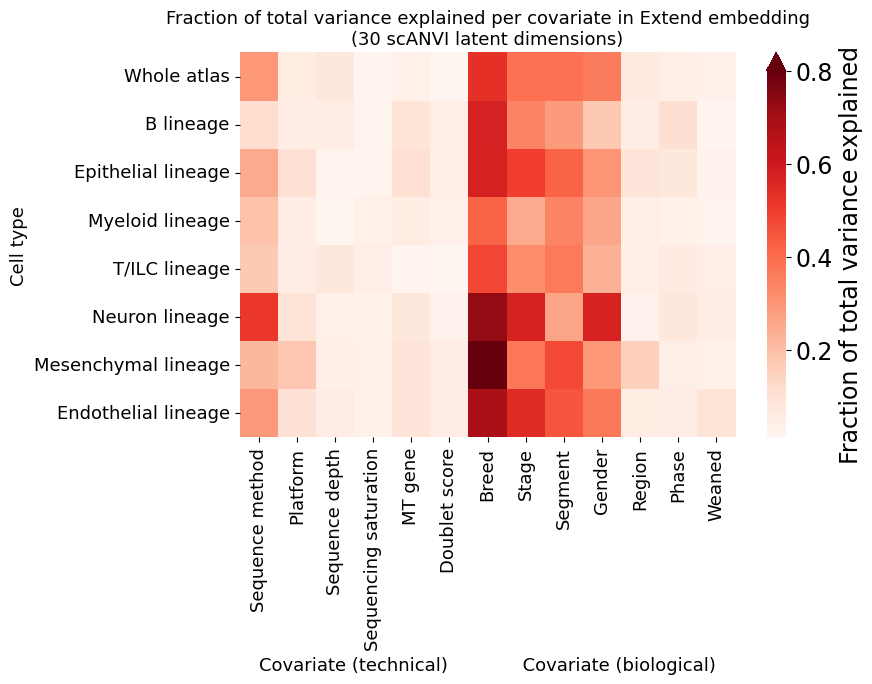

In [426]:
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
fig, ax = plt.subplots(figsize=(8, 5))  # figsize
vmax = 0.8
title = "Fraction of total variance"
# for file storing:
title_no_spaces = title.replace(" ", "_")
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax,
    vmax=vmax,
    cbar_kws={"extend": "max"},
    mask=mask_overall.loc[vars_expl_to_plot.index, vars_expl_to_plot.columns].values,
    cmap=cmap,
)
ax.collections[0].colorbar.set_label(f"{title} explained", fontsize=fz + 4)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fz)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fz)
plt.title(
    f"{title} explained per covariate in Extend embedding\n(30 scANVI latent dimensions)",
    fontsize=fz,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fz + 4)
plt.xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
plt.ylabel("Cell type", fontsize=fz)
plt.savefig(f'/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/cov_extend/new_cov_var_extend.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
# FIGURES[f"4a_{title_no_spaces}_explained_per_covariate_{int_type}_emb"] = fig